<a href="https://colab.research.google.com/github/kyokicchi/ggl_an_codes/blob/master/LGBmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# initialize & load

In [1]:
!pip install lightgbm

    100% |████████████████████████████████| 1.1MB 15.8MB/s 


In [0]:
import lightgbm as lgb

from google.colab import drive
from google.colab import files

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import pickle

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%cd ../content/gdrive/My Drive/projects/ggl_an/
%ls

/content/gdrive/My Drive/projects/ggl_an
model_LGB.sav  output_LGB.csv  user_test.csv    user_train.csv
model_NN.h5    output_NN.csv   user_test_n.csv  user_train_n.csv


In [5]:
%%time

df_train = pd.read_csv('user_train.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv('user_test.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

df_y = df_train['transactionRevenue']
df_x = df_train.drop(['transactionRevenue'], axis=1)
df_tgt = df_test.drop(['transactionRevenue'], axis=1)

filename = 'model_LGB.sav'
model = pickle.load(open(filename, 'rb'))

CPU times: user 4.69 s, sys: 641 ms, total: 5.33 s
Wall time: 8.88 s


In [6]:
df_x.shape, df_y.shape, df_tgt.shape

((714167, 23), (714167,), (617242, 23))

In [7]:
%%time
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y)

CPU times: user 461 ms, sys: 7.13 ms, total: 468 ms
Wall time: 468 ms


In [8]:
x_train.shape, y_train.shape, x_test.shape,  y_test.shape 

((535625, 23), (535625,), (178542, 23), (178542,))

In [0]:
from sklearn.model_selection import GridSearchCV

def applyGSCV(model, param, X, Y, N):
    res = GridSearchCV(model, param, cv=N)
    res.fit(X, Y)
    return res

In [0]:
model = lgb.LGBMRegressor()

param = {
    'learning_rate': [0.1],
    'n_estimators': [200],
    'num_leaves': [100],
}

In [12]:
%%time

model_LGB = applyGSCV(model, param, x_train, y_train, 3)

CPU times: user 1min 56s, sys: 1.33 s, total: 1min 57s
Wall time: 1min


In [13]:
print(model_LGB.best_score_)
print(model_LGB.best_estimator_)

0.3855740667812348
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=200, n_jobs=-1, num_leaves=100, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [14]:
%%time
model = lgb.LGBMRegressor(colsample_bytree=1.0,learning_rate=0.1,
       min_child_samples=20,n_estimators=200,num_leaves=100,
       reg_alpha=0.0, reg_lambda=0.0)

model.fit(x_train, 
          y_train,
          eval_set=[(x_train, y_train),(x_test, y_test)],
          eval_metric='rmse',
          early_stopping_rounds = 300)

[1]	training's l2: 7.93716	training's rmse: 2.8173	valid_1's l2: 6.90662	valid_1's rmse: 2.62805
Training until validation scores don't improve for 300 rounds.
[2]	training's l2: 7.35639	training's rmse: 2.71227	valid_1's l2: 6.38931	valid_1's rmse: 2.52771
[3]	training's l2: 6.87919	training's rmse: 2.62282	valid_1's l2: 5.97543	valid_1's rmse: 2.44447
[4]	training's l2: 6.48314	training's rmse: 2.5462	valid_1's l2: 5.63841	valid_1's rmse: 2.37453
[5]	training's l2: 6.15608	training's rmse: 2.48114	valid_1's l2: 5.37168	valid_1's rmse: 2.31769
[6]	training's l2: 5.88511	training's rmse: 2.42592	valid_1's l2: 5.16577	valid_1's rmse: 2.27283
[7]	training's l2: 5.65732	training's rmse: 2.37851	valid_1's l2: 5.00357	valid_1's rmse: 2.23687
[8]	training's l2: 5.46503	training's rmse: 2.33774	valid_1's l2: 4.85911	valid_1's rmse: 2.20434
[9]	training's l2: 5.30002	training's rmse: 2.30218	valid_1's l2: 4.75587	valid_1's rmse: 2.18079
[10]	training's l2: 5.15794	training's rmse: 2.27111	vali

# evaluate model

In [15]:
%%time
from sklearn.metrics import mean_squared_error

pred = model.predict(df_x)
mse = mean_squared_error(df_y, pred)
rmse = np.sqrt(mse)
print(rmse)

1.77835103738929
CPU times: user 19.7 s, sys: 15.1 ms, total: 19.7 s
Wall time: 10.1 s


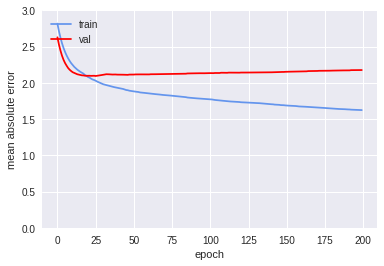

In [21]:
y = model.evals_result_['training']['rmse']
z = model.evals_result_['valid_1']['rmse']
x = range(len(y))


import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y, color='cornflowerblue', label = 'train')
plt.plot(x, z, color='red', label = 'val')
plt.legend(loc="upper left")
plt.ylim(0, 3)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.show()

In [0]:
%%time
pickle.dump(model_LGB, open(filename, 'wb'))

CPU times: user 184 ms, sys: 4.02 ms, total: 188 ms
Wall time: 366 ms


# Predict / Output

In [0]:
%%time
pred_tgt = model.predict(df_tgt)


CPU times: user 19.2 s, sys: 63.9 ms, total: 19.2 s
Wall time: 9.86 s


In [0]:
pred_tgt.min(),pred_tgt.max(),len(pred_tgt[pred_tgt>0]) / len(pred_tgt)  

(-17.62574618750795, 123.55485937634258, 0.7848671995748832)

In [0]:
%%time

pred_tgt[pred_tgt<0] = 0
df_out = pd.DataFrame(index = df_tgt.index)
df_out['PredictedLogRevenue'] = pred_tgt

df_out.to_csv('output_LGB.csv')

In [0]:
df_out.head()

,PredictedLogRevenue
fullVisitorId,
0000000259678714014,0.501595
0000049363351866189,0.000000
0000053049821714864,0.000000
0000059488412965267,0.000545
0000085840370633780,0.000239


In [0]:
df_out.describe()

,PredictedLogRevenue
count,617242.000000
mean,0.195767
std,1.377942
min,0.000000
25%,0.000239
50%,0.000239
75%,0.001224
max,123.554859
